In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble, subnetwork

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('cpu')

In [3]:
y_mean = torch.mean(y_train)
y_sd = torch.std(y_train)

y_train = (y_train - y_mean) / y_sd

In [4]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [10, 10], learning_rate = 0.001)

initial loss:  1.226679801940918
final loss:  -3.3715715408325195
initial loss:  0.9651733636856079
final loss:  -3.308821439743042
initial loss:  1.011692762374878
final loss:  -3.5033960342407227
initial loss:  0.9722986817359924
final loss:  -3.3761706352233887
initial loss:  1.154361367225647
final loss:  -3.482539415359497


Deep ensemble test MAPE:  0.34307152
Deep ensemble test RMSE:  44.738598
Deep ensemble test NLLK:  7.500284
Deep ensemble test CRPS:  tensor(17.6476)


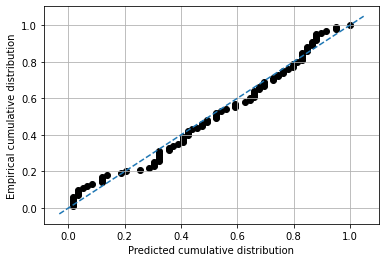

Deep ensemble test calibration error when step size is 0.001:  1.242400316001149
Deep ensemble test calibration error when step size is 0.01:  0.12545101982189022
Deep ensemble test calibration error when step size is 0.1:  0.0102987647227808


In [5]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [6]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.87it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.79it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.70it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           24.211
  RMSE          44.739
  MDAE          11.141
  MARPD         31.069
  R2            0.889
  Correlation   0.954
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.028
  Mean-absolute Calibration Error       0.024
  Miscalibration Area                   0.024
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.232
     Group Size: 0.56 -- Calibration Error: 0.072
     Group Size: 1.00 -- Calibration Error: 0.024
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.245
     Group Size: 0.56 -- Calibration Error: 0.092
     Group Size: 1.00 -- Calibration Error: 0.028
============

Lims is None. Setting lims now:
min_max_true: (7.0, 915.0)
min_max_pred: (12.124474, 926.75037)
lims: (7.0, 926.75037)
lims_ext: (-84.97503662109375, 1018.7254028320312)


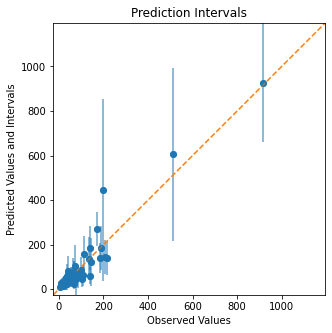

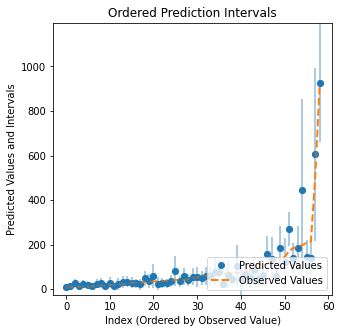

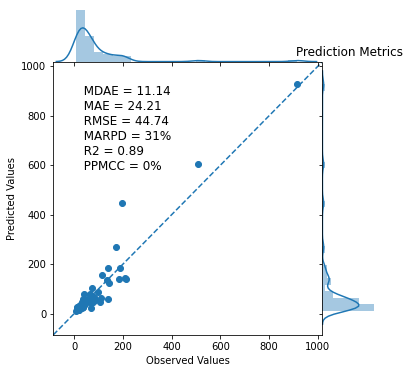

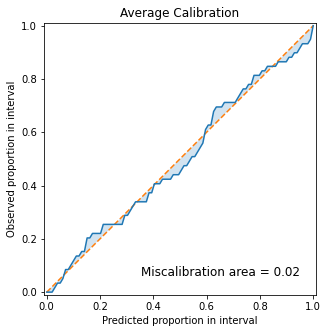

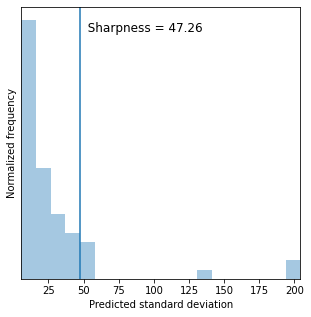

In [7]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [8]:
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train, n_epoch = 500, n_features = 30, learning_rate = 0.01)

final loss:  -4.887641429901123


Concrete dropout test MAPE:  0.36691257
Concrete dropout test RMSE:  39.89144
Concrete dropout test NLLK:  10.066988
Concrete dropout test CRPS:  tensor(18.2961)


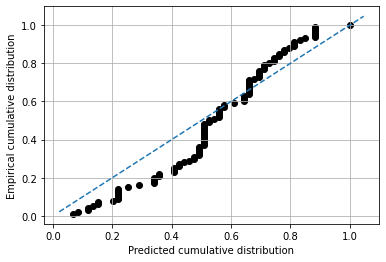

Concrete dropout test calibration error when step size is 0.001:  9.390106722206262
Concrete dropout test calibration error when step size is 0.01:  0.9299899454179831
Concrete dropout test calibration error when step size is 0.1:  0.09268888250502727


In [9]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy()) * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [10]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.16it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.08it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.09it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           23.835
  RMSE          39.891
  MDAE          11.526
  MARPD         32.658
  R2            0.912
  Correlation   0.967
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.168
  Mean-absolute Calibration Error       0.153
  Miscalibration Area                   0.155
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.301
     Group Size: 0.56 -- Calibration Error: 0.198
     Group Size: 1.00 -- Calibration Error: 0.153
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.336
     Group Size: 0.56 -- Calibration Error: 0.222
     Group Size: 1.00 -- Calibration Error: 0.168
============

Lims is None. Setting lims now:
min_max_true: (7.0, 915.0)
min_max_pred: (18.311394, 1033.8578)
lims: (7.0, 1033.8578)
lims_ext: (-95.68577880859375, 1136.5435668945313)


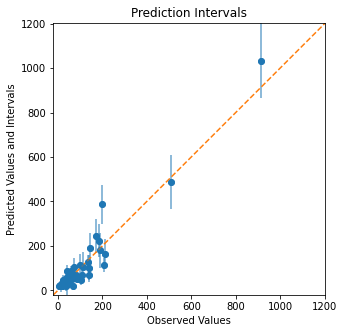

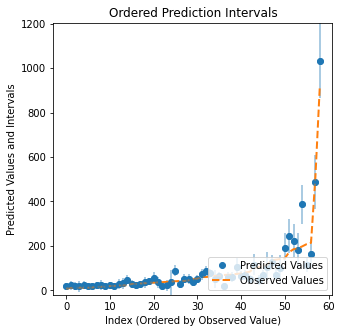

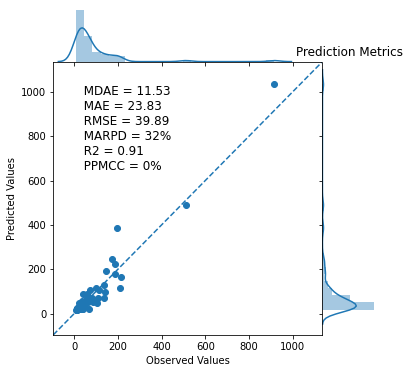

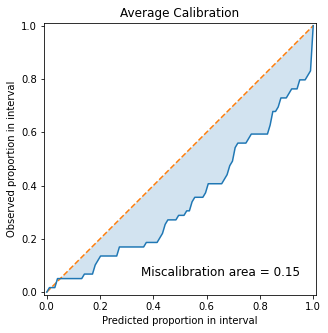

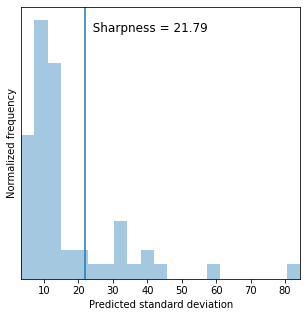

In [11]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [12]:
subnetwork_model = subnetwork.train_model(x_train, y_train, n_epoch = 500, hidden_layers = [10, 10], learning_rate = 0.001)

initial loss:  1.191420078277588
final loss:  -2.341135025024414


Subnetwork test MAPE:  0.3748453
Subnetwork test RMSE:  59.302002
Subnetwork test NLLK:  7.532173
Subnetwork test CRPS:  tensor(20.1840)


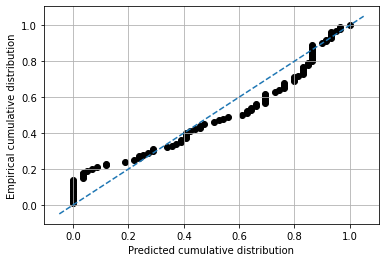

Subnetwork test calibration error when step size is 0.001:  5.74527075553002
Subnetwork test calibration error when step size is 0.01:  0.5739485779948289
Subnetwork test calibration error when step size is 0.1:  0.06229531743751797


In [13]:
mean_pred, var_pred = subnetwork.test_model(subnetwork_model, x_test)
mean_pred = mean_pred.detach().numpy() * y_sd.detach().numpy()+ y_mean.detach().numpy()
var_pred = var_pred.detach().numpy() * torch.pow(y_sd, 2).detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Subnetwork test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Subnetwork test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Subnetwork test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Subnetwork test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Subnetwork test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Subnetwork test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Subnetwork test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [14]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.66it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.51it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           27.700
  RMSE          59.302
  MDAE          10.765
  MARPD         32.141
  R2            0.806
  Correlation   0.902
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.106
  Mean-absolute Calibration Error       0.093
  Miscalibration Area                   0.094
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.249
     Group Size: 0.56 -- Calibration Error: 0.138
     Group Size: 1.00 -- Calibration Error: 0.093
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.273
     Group Size: 0.56 -- Calibration Error: 0.149
     Group Size: 1.00 -- Calibration Error: 0.106
============

Lims is None. Setting lims now:
min_max_true: (7.0, 915.0)
min_max_pred: (19.484833, 555.0472)
lims: (7.0, 915.0)
lims_ext: (-83.80000000000001, 1005.8)


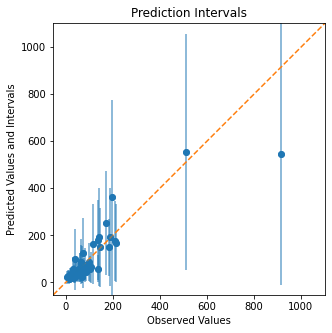

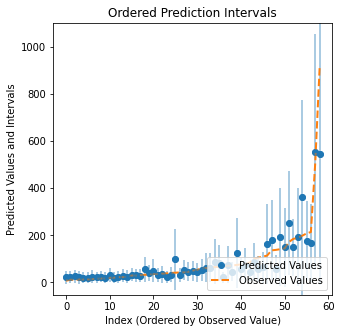

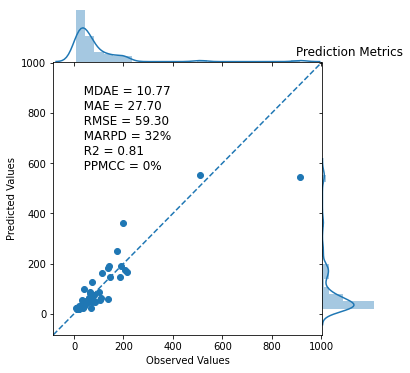

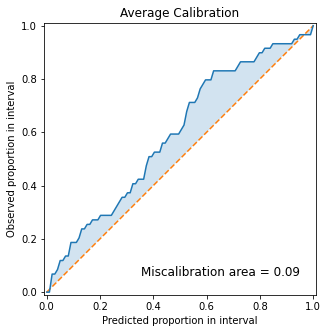

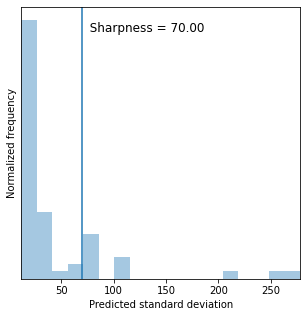

In [15]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))